# Repository
This work has been refactored and added to a [github repository](https://github.com/kareemalsawah/oxford_flowers_model) that is cloned and used in this notebook.

# Dataset Exploration and Analysis

In [ ]:
# Download and unzip dataset
!git clone https://github.com/kareemalsawah/oxford_flowers_model
!wget https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
!tar -xzf oxford-102-flowers.tgz -C ./
!rm oxford-102-flowers.tgz

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
from oxford_flowers_model.modules import *
sns.set()
%matplotlib inline

# Understanding the dataset
### Semantics
The dataset is made of images of flowers each with a unique class. It seems that classes are mainly dependent on how the flower looks (taxonomy/species).

### Structure
The dataset is divided into train, valid, and test. All images exist in a single folder (each with a unique name/id). 3 files train.txt, valid.txt, and test.txt match each of these images to 1 class. There are no repeated images across the train, valid, and test sets (no leaks).

The data contains 1020 train, 1020 validation, and 6149 testing images. This seems like a bad way to split the data. A better ratioo would be 70, 15, 15. This would leave around 1250 for testing which is reasonable for 102 classes (this would depend on how critical the application is as well). The given split is used in the initial modeling phase.

### EDA
See the next few code blocks
#### Class distributions
Seems like classes are uniformly distributed in training and validation dataset.

Test dataset seems to not be uniformly distributed; this leads me to believe that validation and training data have been preprocessed to have balanced classes (as indicated by the perfectly uniform distribution).

Personally, I don't like solving imbalanced classes like this as the model would be learning a distribution different from the real world distribution. I would try to use other regularization methods when possible or use balanced classes but fine tune the model at the end on the imbalanced classes. My approach can be affected by the specific problem at hand as well and whether bias would be beneficial or not.

For this problem, I will ignore the fact that test data has a different distribution and work with train and valid as is.

Note: The only EDA I do on the test data is to make sure it is distributed similar to the training data; otherwise, I would be solving the wrong problem. Any further EDA would be a form of data leak.



Number of train rows: 1020
Number of valid rows: 1020
Number of test rows: 6149
Number of train classes: 102
Number of valid classes: 102
Number of test classes: 102


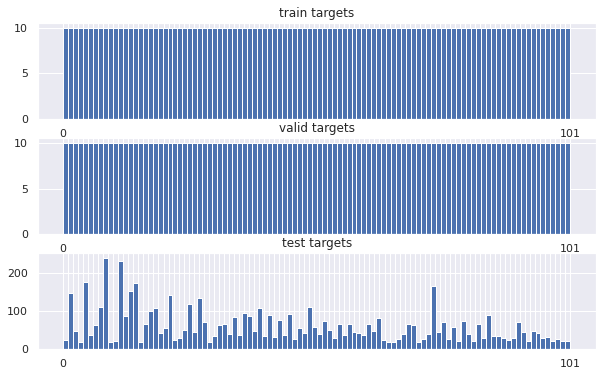

No data leaks found


In [ ]:
data = load_dataframes()
class_dists(data)
check_leaks(data)

### Analyzing the images
Most images have a height of 500 with some outliers visualized below.

Width of the images is multimodal with 3 modes at 500, 660, and 780 respectively. Samples from each mode is visualized as well as outliers.

Some of the classes have very low interclass variation and are very unique from all other classes; however, there are classes with large interclass variation with great similarity to other classes. These classes should be expected to have high confusion after training.

Low interclass variation: [48,49,62,99] (Most classes lie in this group)

High interclass variation: [2,67,72,73]

/content/oxford_flowers_model/modules/datasets.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(imgs)


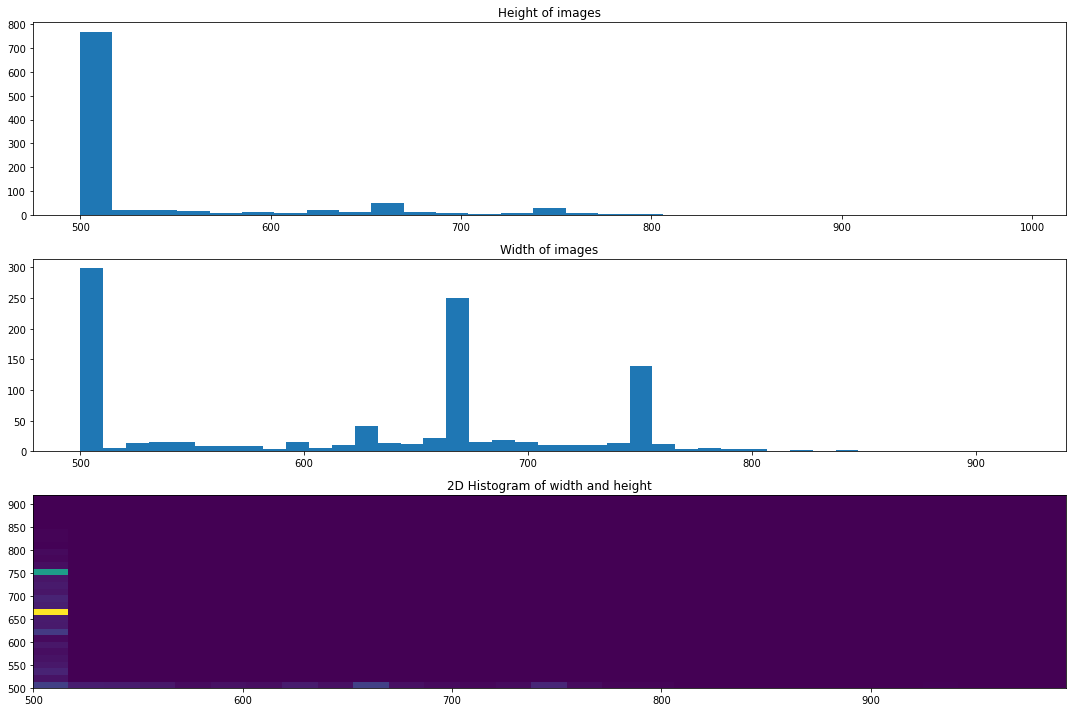

In [ ]:
sns.reset_orig()
imgs = load_imgs(data['train']['img_path'].values)
img_size_hists(imgs)

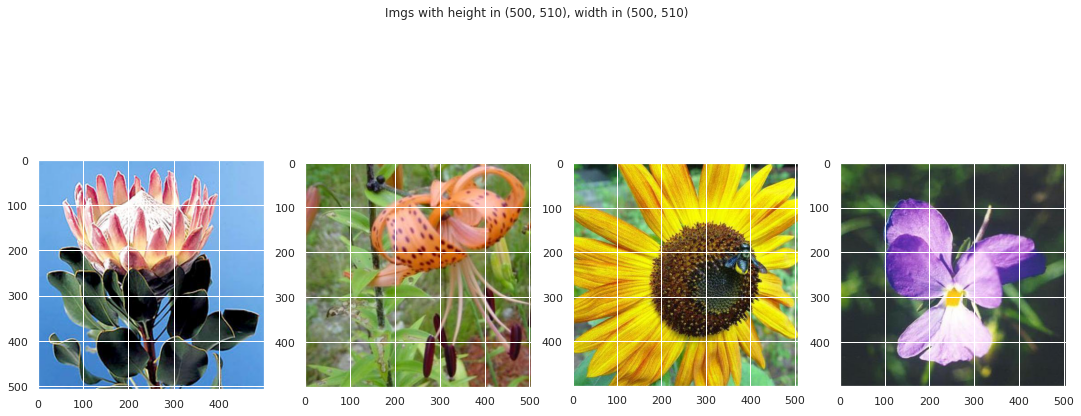

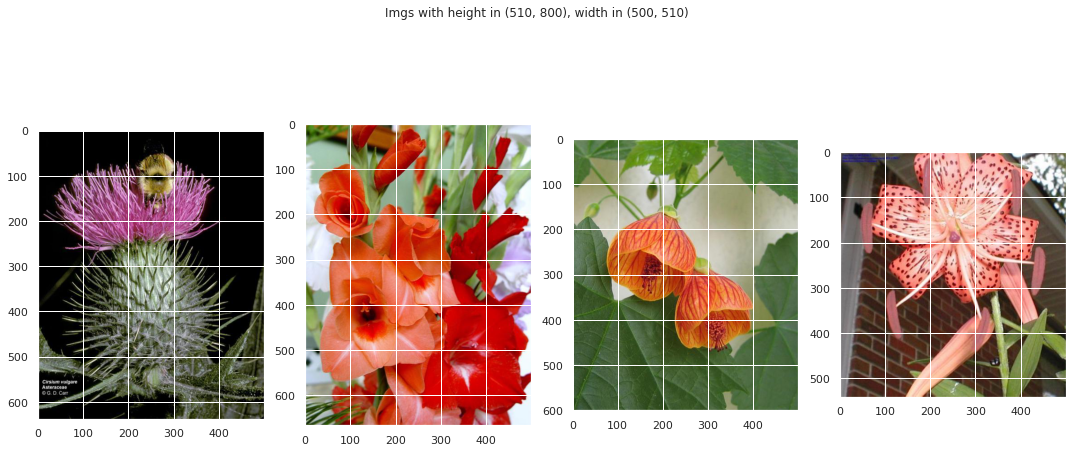

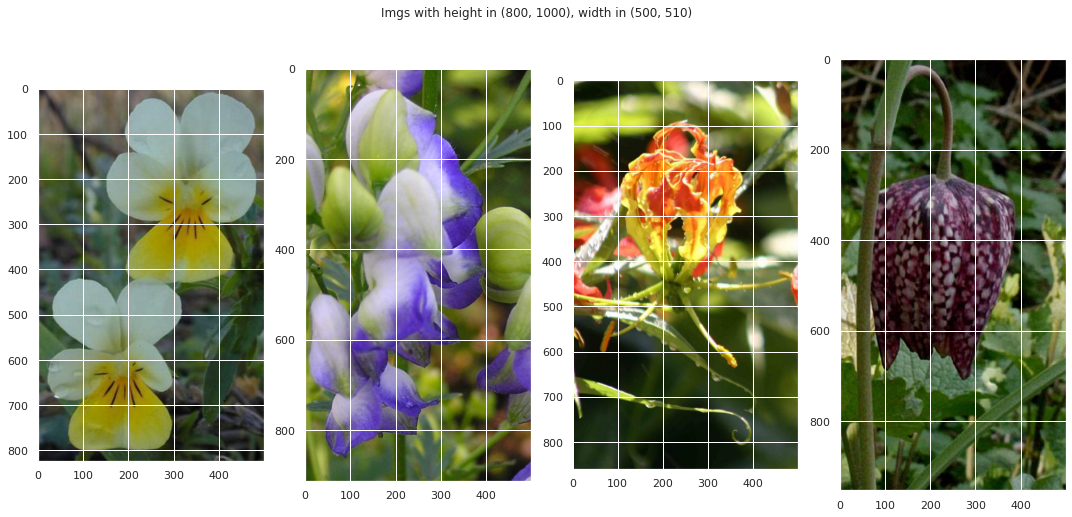

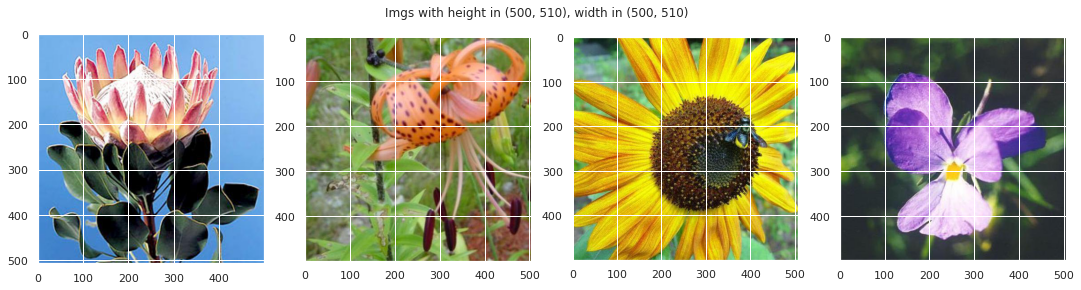

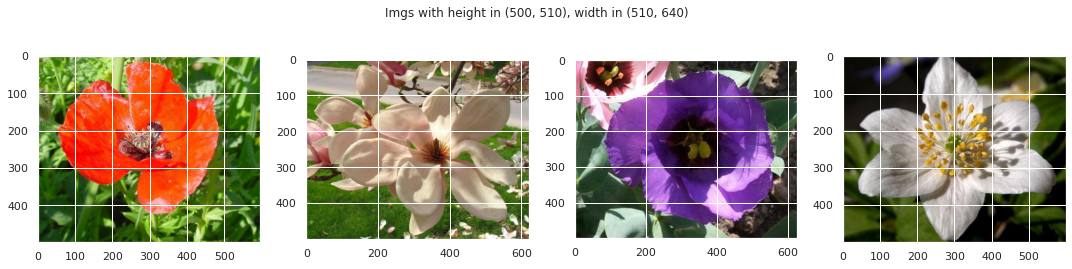

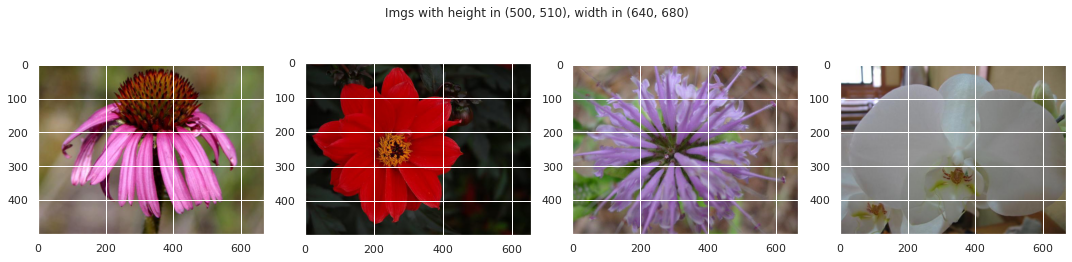

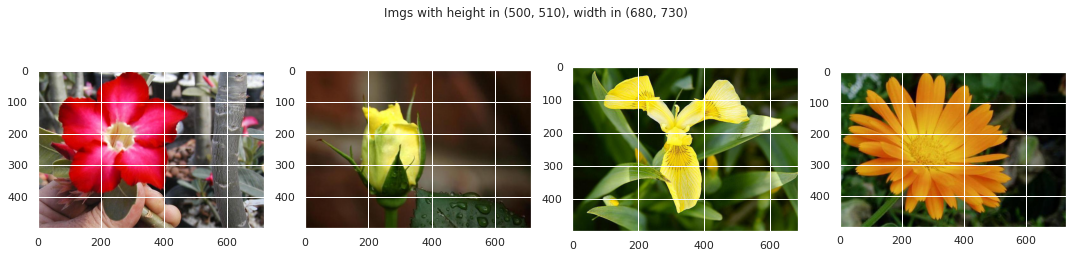

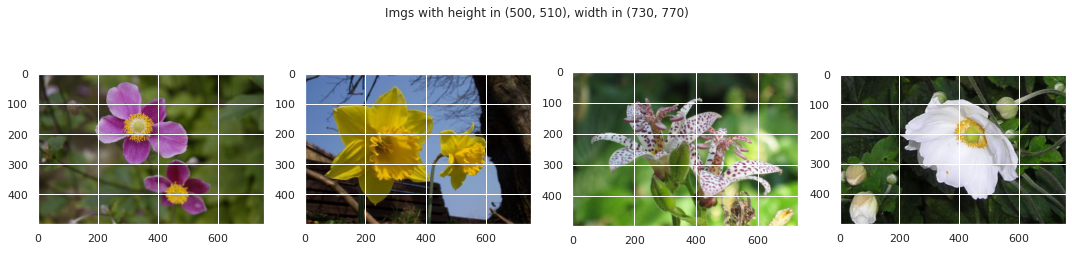

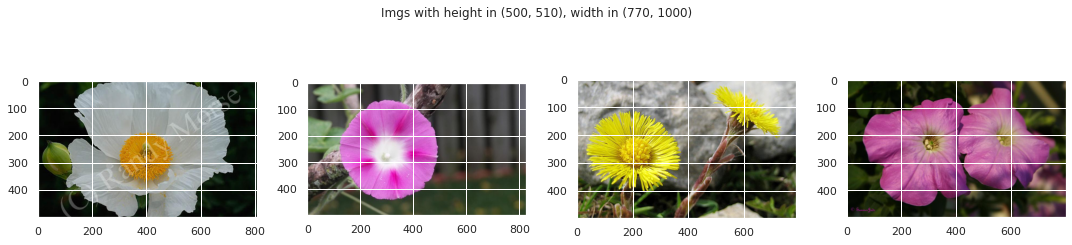

In [ ]:
plot_imgs_diff_sizes(imgs)

In [ ]:
# Images by class, output omitted to reduce size of the notebook
# This cell plots 5 samples of images from each class
labels = data['train']['target'].values.astype(int)
plot_imgs_from_classes(imgs,labels)

### Transformations applied to the data
Given the previous analysis, it was observed that some flowers are either tall or wide, and so their images also are taller/wider than the average of 500x500.

In [ ]:
# Training Hyperparameters
batch_size = 32
use_cuda = True
img_size = 224
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

In [ ]:
# Datasets
train_transform_aug = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(img_size),
                                        transforms.RandomResizedCrop(img_size),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(img_mean, img_std)])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(img_size),
                                        transforms.CenterCrop(img_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(img_mean, img_std)])

viz_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(img_size),
                                        transforms.CenterCrop(img_size),
                                        transforms.ToTensor()])

loaders = get_dataloaders(batch_size, train_transform_aug, test_transform, add_test=True)

/content/oxford_flowers_model/modules/datasets.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(imgs)


# Modeling using ResNet50
#### Training Phases
1) Only training the classification head (freeze the earlier pretrained layers of the model)

2) Fine tune the earlier layers with a smaller learning rate

### What happened while modeling
#### 1) First attempt using a 1x1 convolution instead of avg pool layer in final part of the resnet
Model overfitted significantly

#### 2) Use Avg pool, add dropout and weight decay and final training step using data augmentation



In [ ]:
model = resnet_model()
if use_cuda:
    model = model.cuda()

100%|██████████| 10/10 [02:31<00:00, 15.10s/it]


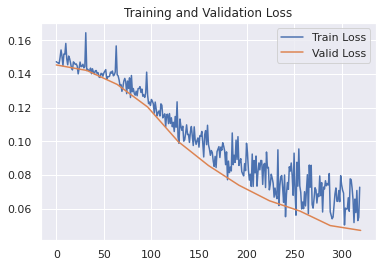

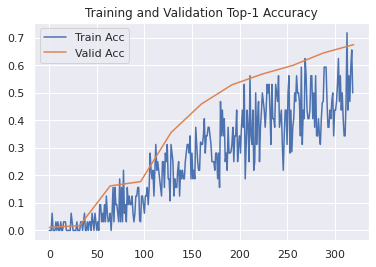

In [ ]:
model.freeze()
train(model,loaders,10,1e-3, weight_decay=0.0)

100%|██████████| 10/10 [02:31<00:00, 15.11s/it]


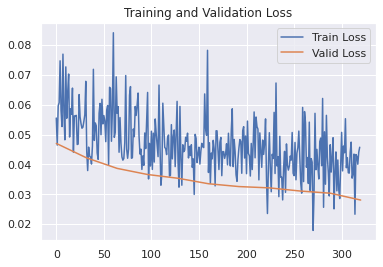

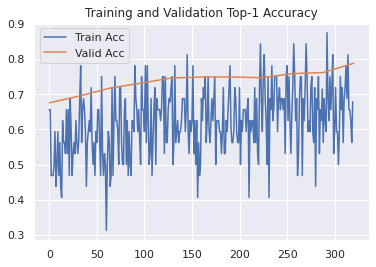

In [ ]:
train(model,loaders,10,5e-4)

100%|██████████| 10/10 [03:43<00:00, 22.35s/it]


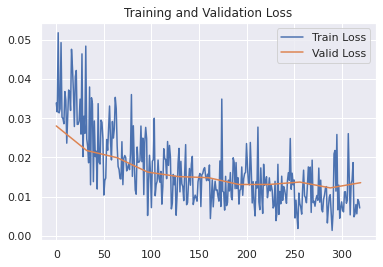

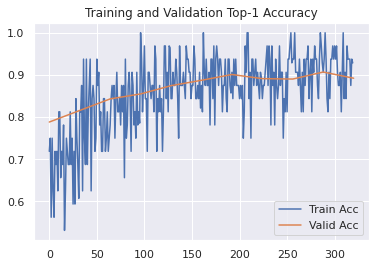

100%|██████████| 10/10 [03:44<00:00, 22.44s/it]


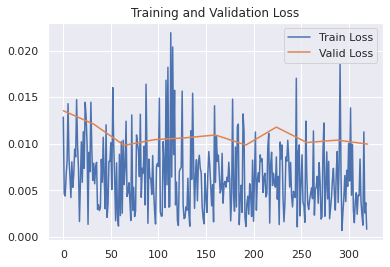

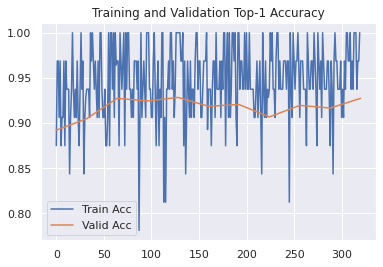

In [ ]:
model.unfreeze(-1)
train(model,loaders,10,1e-4)
train(model,loaders,10,5e-5)

# Evaluate
Top-1 Test Accuracy: 88.89 %

Test Precision: 87.50 %

Test F1: 88.30 %

Worst Classes (in F1): [2,  3, 38]

Best Classes (in F1): [60, 58, 26]

100%|██████████| 193/193 [01:11<00:00,  2.71it/s]


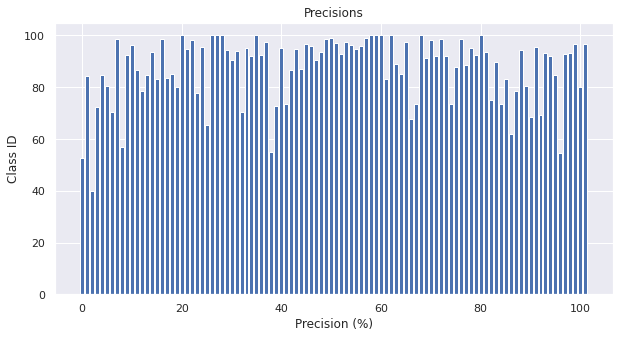

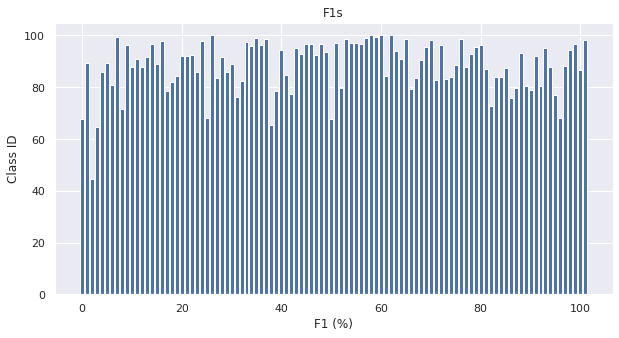

Best classes in precision [20 80 68]
Worst classes in precision [ 2  0 96]
Best classes in F1 [60 58 26]
Worst classes in F1 [ 2  3 38]
Overall Accuracy: 88.89250284599122%
Overall Precision: 87.49726567066122%
Overall F1: 88.29701552465917%


/content/oxford_flowers_model/modules/datasets.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(imgs)


In [ ]:
sns.set()
# Evaluating Precision, Accuracy, F1
hard_imgs, corrects = evaluate(model,loaders['test'], 32)

# GRADCAM

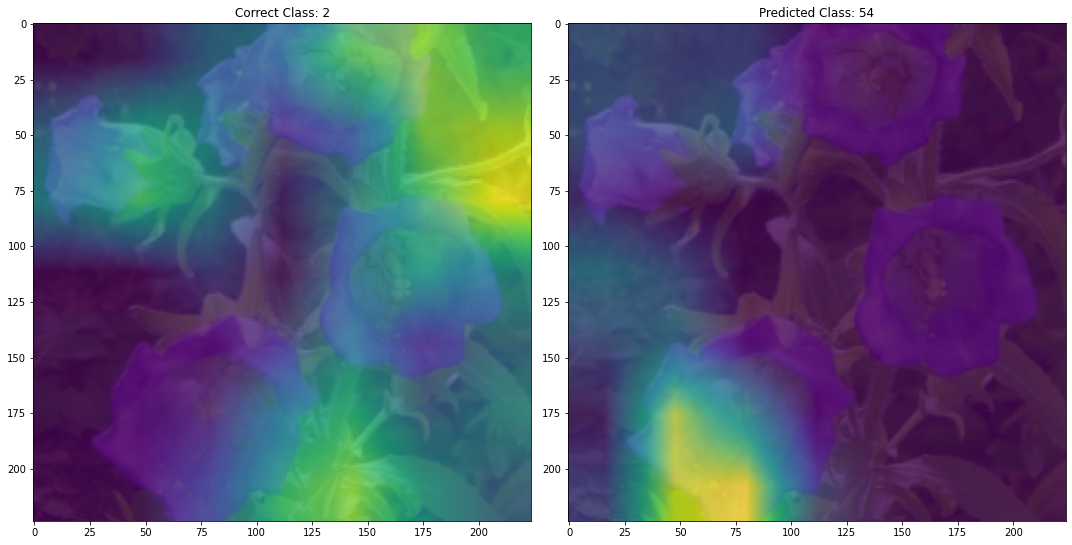

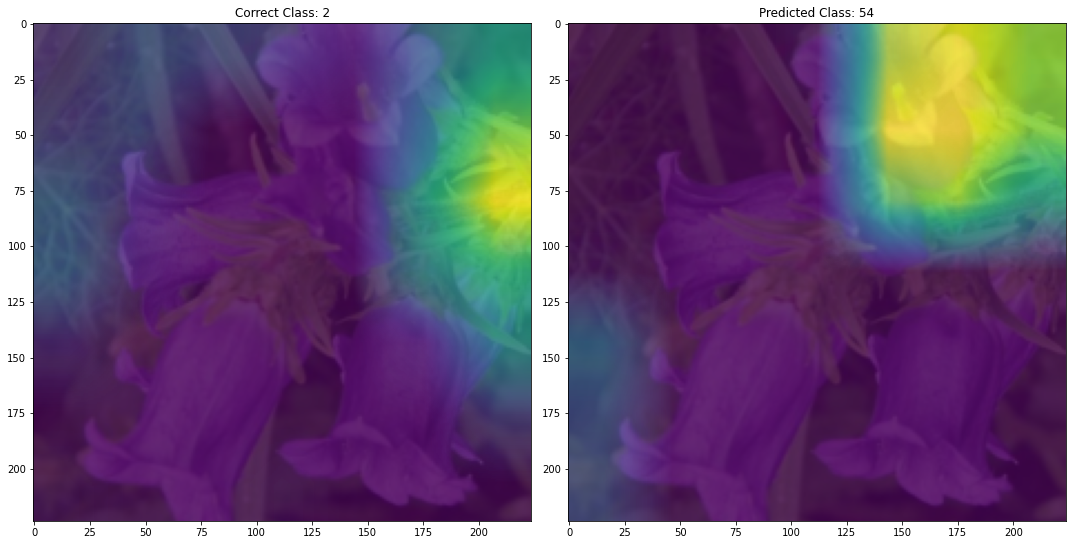

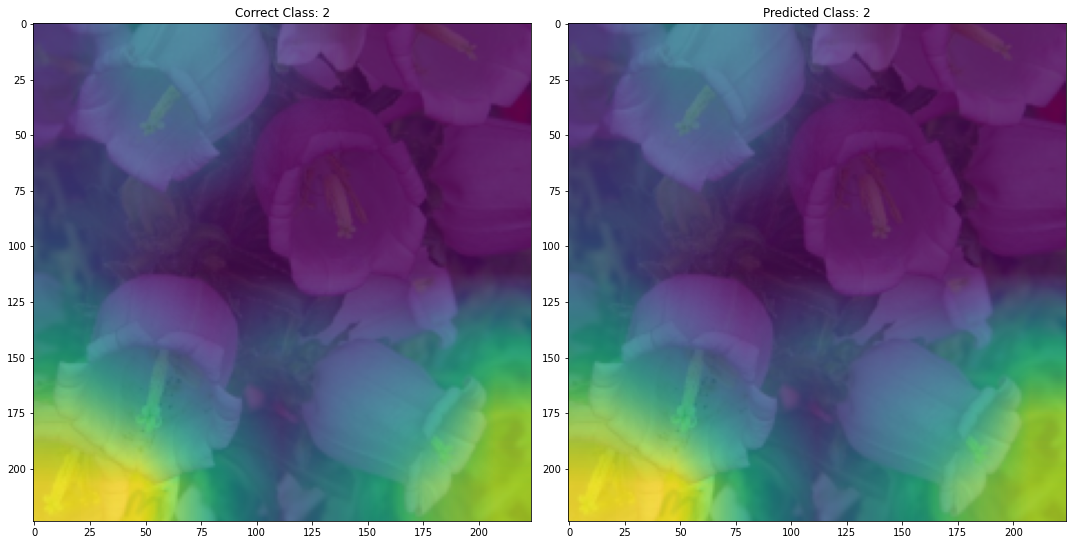

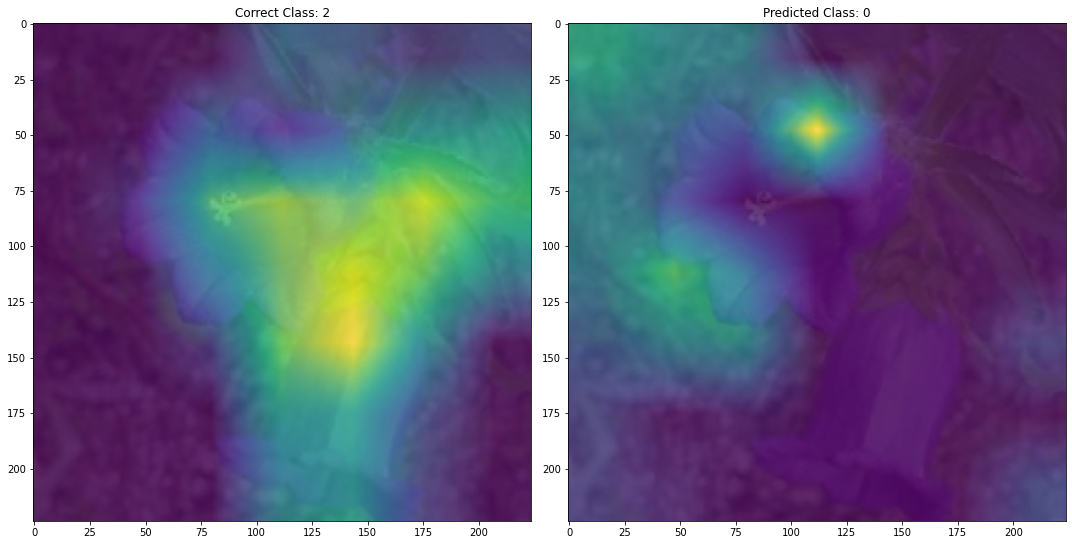

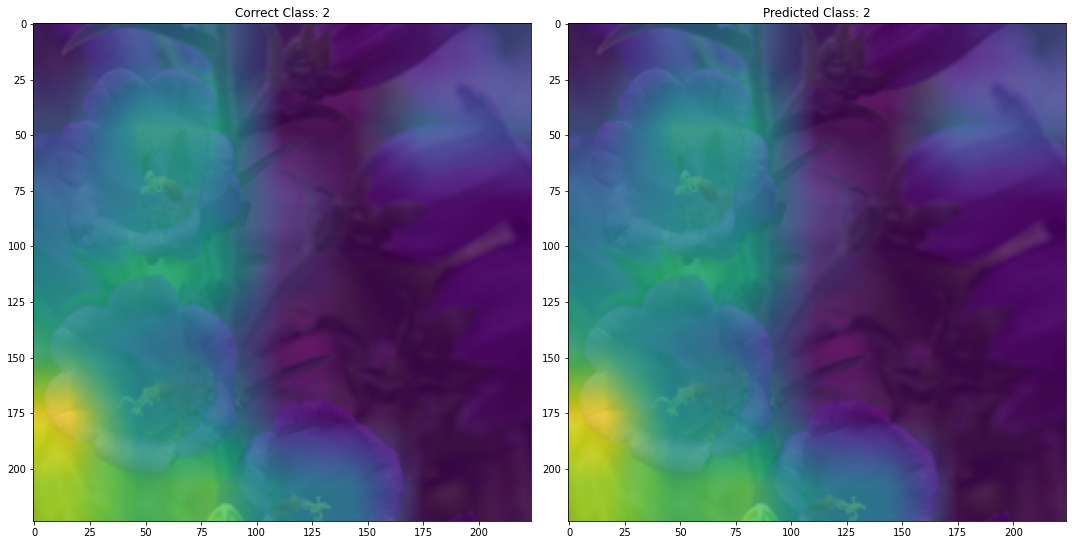

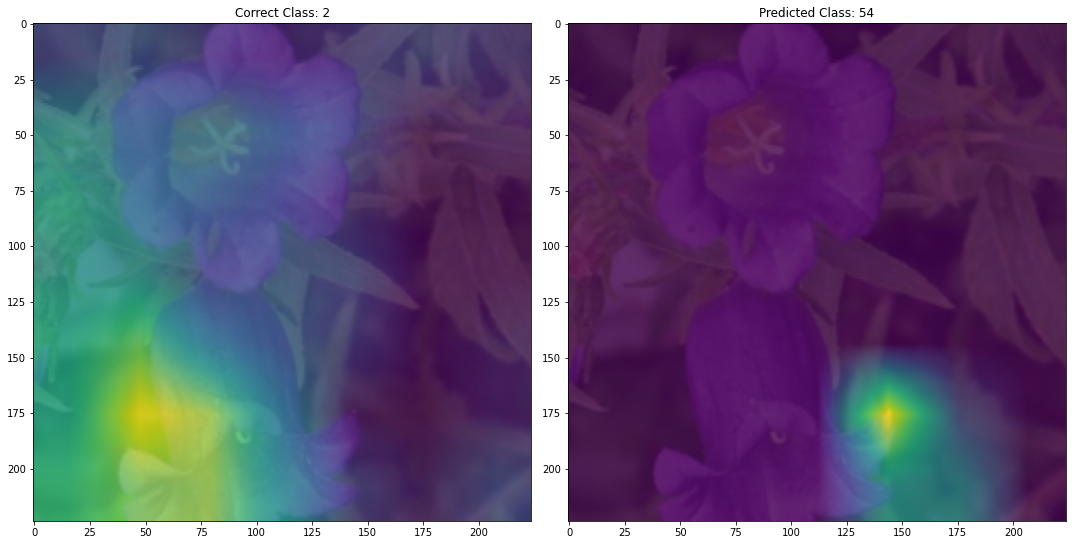

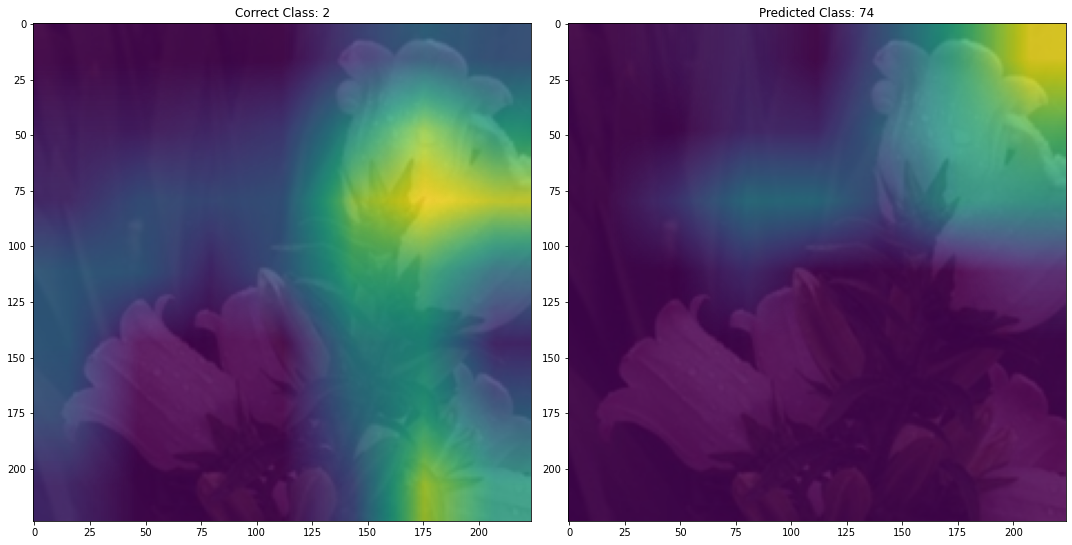

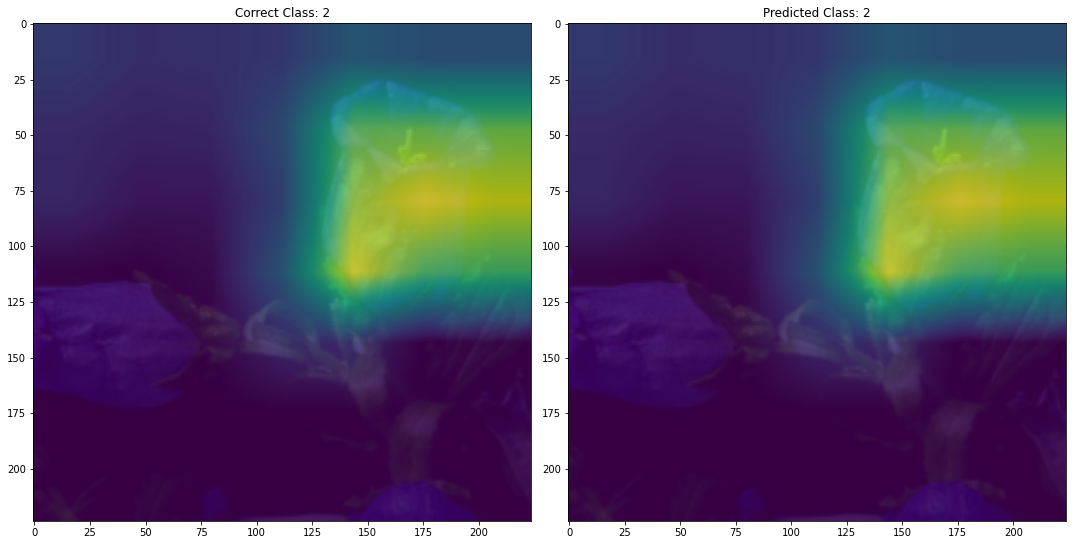

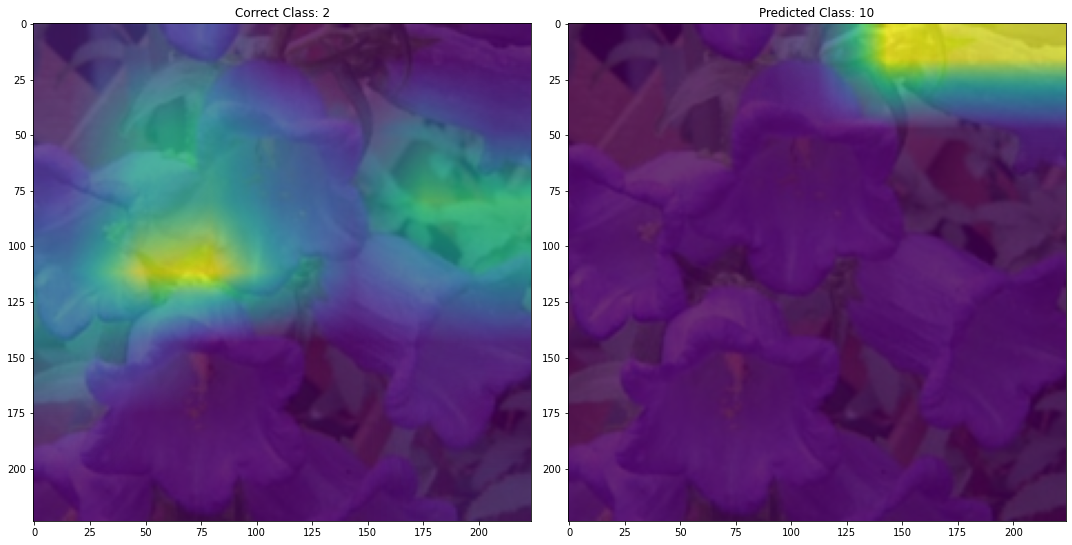

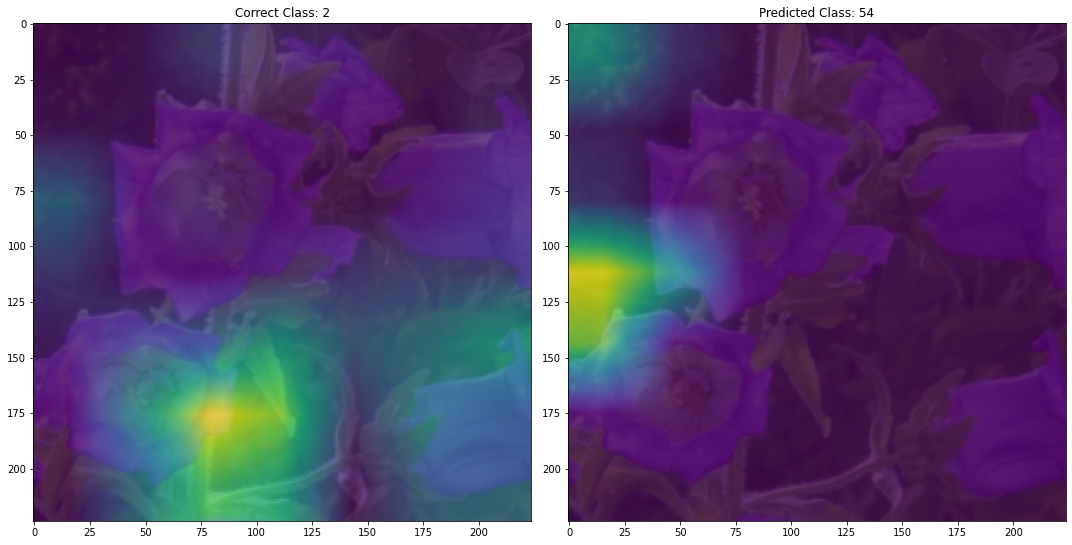

In [ ]:
# View GRADCAM
sns.reset_orig()
new_imgs = []
for img in hard_imgs:
    new_imgs.append(viz_transform(img).numpy())
new_imgs = torch.from_numpy(np.array(new_imgs))
grad_cam_viz(model, new_imgs, torch.from_numpy(corrects))

# What could be done to improve the model during test time without retraining?
* TTA (Test Time Augmentation). It's issue is higher computational cost.

# Other changes
* I would probably try models smaller than resnet50 to help with the overfitting